<a href="https://colab.research.google.com/github/hima111997/2015lab1/blob/master/Covid-19%20detection%20using%20Deep%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Model with Transfer Learning to detect COVID-19 in chest X-ray images using TensorFlow**

* steps:
1. I downloaded the data from the following Kaggle database https://www.kaggle.com/khoongweihao/covid19-xray-dataset-train-test-sets
2. Training and test images images were cropped manually to remove the annotations from the images and leave only the X-ray images of chest.
3. Google Colaboratory was used as it provides free GPU support to train my model.
4. Transfer learning (InceptionV3 with imagenet wieghts) with TensorFlow was used in training.
5. I tried two cases:
  * 1. Images (test and train) with enhancement using **Adaptive Histogram Equalization** from skimage ( this was a recommendation from a friend of mine this is his paper https://www.researchgate.net/publication/341165032_Detecting_COVID-19_via_Chest_X-rays_Using_Deep_Learning )
  * 2. Images without enhancement
6. Images with enhancement gave the best result and this is shown in this notebook
7. Metrics such as :
  * 1. confusion matrix
  * 2. precision
  * 3. recall

  were calculated.

* If you have any comments or recommendations please feel free to tell me. I am just a learner. 
* This work is just an application after I learnt about the CNN for the first time from Prof. **Andrew NG** on coursera. I greatly thank him. His specialization is the best.

* without advice from my friends specialized in computer science I would not be able to reach this point. Thank you Ali Osama, Ali Mostafa, and Omar mahmoud


# importing important libraries

In [24]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K
from tensorflow.keras import layers, Model
from tensorflow.math import confusion_matrix
import datetime

K.set_image_data_format('channels_last')
K.set_learning_phase(1)
%load_ext tensorboard





The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# loading pretrained model 

In [25]:
pre_trained_model = InceptionV3(input_shape = (200, 200, 3), 
                                include_top = False, 
                                weights = 'imagenet')
pre_trained_model.summary()

87916544/87910968 [==============================] - 2s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
______________________

# freezing all the layers and adding some Dense layers

In [0]:
pre_trained_model.trainable = False # freezing all layers. if you want to freeze some of them select them or use for loop

#pre_trained_model.summary()
last_layer = pre_trained_model.output

X = GlobalAveragePooling2D()(last_layer)
X = layers.Flatten()(X)
X = layers.Dense(10000, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(5000, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(1000, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(500, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dropout(.5)(X)
X = layers.Dense(100, activation = 'relu', kernel_initializer = glorot_uniform(seed=0))(X)
X = layers.Dense(1, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)


tf_model = Model(inputs = pre_trained_model.input, outputs = X) 

#print(tf_model.summary())


# creating image generators

In [27]:
valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training ImagaDataGenerator with Augmentation transf.  
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   zca_whitening = True,
                                   fill_mode='constant',
                                   brightness_range=[0.7,1.3],   
                                   cval = 255,   
                                   horizontal_flip=True,
                                   zoom_range=[0.75,1])          

valid_gen = valid_datagen.flow_from_directory('/content/drive/My Drive/covid_my_data/enhanced/train',
                                              subset='validation',
                                              seed=42,
                                              target_size=(200, 200),
                                              batch_size=4,
                                              class_mode = 'binary')

# Create a flow from the directory using same seed and 'training' subset.
train_gen = train_datagen.flow_from_directory('/content/drive/My Drive/covid_my_data/enhanced/train',
                                              subset='training',
                                              seed=42,
                                              target_size=(200, 200),
                                              batch_size=8,
                                              class_mode = 'binary') # , save_to_dir= '/content/drive/My Drive/Colab Notebooks/aug'


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 28 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


# adding callbacks

In [0]:
log_dir = "/content/drive/My Drive/Colab Notebooks/covid_logs_new/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
filepath = '/content/drive/My Drive/best_model_with_enhancement.h5'


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy') >= .96 and (0 < logs.get('accuracy') - logs.get('val_accuracy') <= .02):
      self.model.stop_training = True

callback = myCallback()
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False)

# compiling and starting the fun

In [32]:
optim = Adam(lr = 0.001)
tf_model.compile(optimizer=optim,
                 loss='binary_crossentropy',
                 metrics=['accuracy',
                         Recall(),
                         Precision(),
                         AUC(),
                         AUC(curve = 'PR')])

tf_model.fit_generator(train_gen,
                       epochs = 300,
                       steps_per_epoch=15,
                       shuffle=True,
                       validation_data=valid_gen,
                       validation_steps = 12,
                       callbacks=[tensorboard_callback, checkpoint, callback])


Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/300
15/15 [==============================] - 96s 6s/step - loss: 10.7380 - accuracy: 0.5000 - recall: 0.4500 - precision: 0.5000 - auc: 0.5360 - auc_1: 0.5372 - val_loss: 18.0573 - val_accuracy: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000 - val_auc: 0.5000 - val_auc_1: 0.5000
Epoch 2/300
15/15 [==============================] - 20s 1s/step - loss: 7.3498 - accuracy: 0.5500 - recall: 0.5500 - precision: 0.5500 - auc: 0.5412 - auc_1: 0.5386 - val_loss: 3.2891 - val_accuracy: 0.4375 - val_recall: 1.0000 - val_precision: 0.4375 - val_auc: 0.5582 - val_auc_1: 0.4709
Epoch 3/300
15/15 [==============================] - 21s 1s/step - loss: 2.1264 - accuracy: 0.4667 - recall: 0.4500 - precision: 0.4655 - auc: 0.5165 - auc_1: 0.5471 - val_loss: 0.6075 - val_accuracy: 0.7292 - val_recall: 0.4583 - val_precision: 1.0000 - val_auc: 0.8481 - val_auc_1: 0.9012
Epoch 4/300
15/15 [==============================] - 30s 2s/step - loss: 1.0175 - accuracy: 0.6417 - recall: 0.7167 - precisi

# metrics on test data without fine-tuning

Found 40 images belonging to 2 classes.


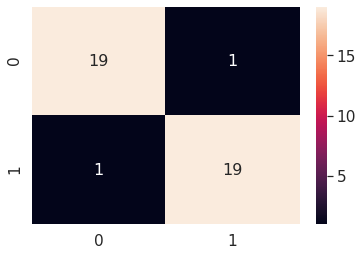

precision: 0.95
recall: 0.95
f1_score: 0.9500000000000001


In [33]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory('/content/drive/My Drive/covid_my_data/new_test/test enhanced',
                                            shuffle=False,
                                            seed=42,
                                            target_size=(200, 200),
                                            batch_size=1,
                                            class_mode = 'binary')


probabilities = tf_model.predict(test_gen, steps = 40)
y_true = test_gen.classes
y_pred = probabilities > 0.5

mat = confusion_matrix(y_true, y_pred).numpy()

df_cm = pd.DataFrame(mat, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred)
print('precision:',precision)
print('recall:', recall)
print('f1_score:',f1_score)

# making some fine-tuning

In [35]:
for idx,layer in enumerate(pre_trained_model.layers):
  print(idx, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [36]:
for layer in tf_model.layers[:249]: # mixed8
  layer.trainable = False
for layer in tf_model.layers[249:]:
  layer.trainable = True

log_dir = "/content/drive/My Drive/Colab Notebooks/covid_logs_new/fit/20200511-120720/" + 'fine_tuned'
filepath = '/content/drive/My Drive/best_model_with_enhancement_finetuned.h5'


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy') >= .96 and (0 < logs.get('accuracy') - logs.get('val_accuracy') <= .02):
      self.model.stop_training = True

callback = myCallback()
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False)

tf_model.fit_generator(train_gen,
                       epochs = 300,
                       steps_per_epoch=15,
                       shuffle=True,
                       validation_data=valid_gen,
                       validation_steps = 12,
                       callbacks=[tensorboard_callback, checkpoint, callback])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/300
15/15 [==============================] - 20s 1s/step - loss: 0.0926 - accuracy: 0.9667 - recall: 0.9683 - precision: 0.9683 - auc: 0.9907 - auc_1: 0.9945 - val_loss: 0.3756 - val_accuracy: 0.9583 - val_recall: 0.9167 - val_precision: 1.0000 - val_auc: 0.9583 - val_auc_1: 0.9739
Epoch 2/300
15/15 [==============================] - 23s 2s/step - loss: 0.0039 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 0.4944 - val_accuracy: 0.9375 - val_recall: 0.8696 - val_precision: 1.0000 - val_auc: 0.9270 - val_auc_1: 0.9514
Epoch 3/300
15/15 [==============================] - 22s 1s/step - loss: 0.2017 - accuracy: 0.9750 - recall: 0.9836 - precision: 0.9677 - auc: 0.9811 - auc_1: 0.9648 - val_loss: 0.3376 - val_accuracy: 0.9167 - val_recall: 0.8519 - val_precision: 1.0000 - val_auc: 0.9612 - val_auc_1: 0.9794
Epoch 4/300
15/15 [==============================] - 22s 1s/step - loss: 0.0556 - accuracy: 0.9917 - recall: 0.9833 - precision

# metrics on fine-tuned model

Found 40 images belonging to 2 classes.


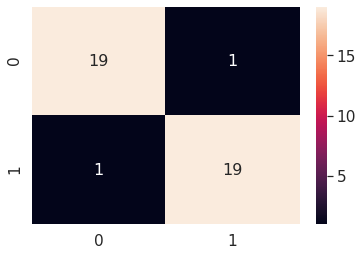

precision: 0.95
recall: 0.95
f1_score: 0.9500000000000001


In [37]:
from tensorflow.math import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory('/content/drive/My Drive/covid_my_data/new_test/test enhanced',
                                              shuffle=False, seed=42, target_size=(200, 200),
                                              batch_size=1, class_mode = 'binary')


probabilities = tf_model.predict(test_gen, steps = 40)
y_true = test_gen.classes
y_pred = probabilities > 0.5

mat = confusion_matrix(y_true, y_pred).numpy()

df_cm = pd.DataFrame(mat, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred)
print('precision:',precision)
print('recall:', recall)
print('f1_score:',f1_score)

# enhancment using skimage

In [0]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure

#plt.figure(figsize=(40, 25))

# train_0 = '/content/drive/My Drive/covid_my_data/train/0/'
# enhanced_train0 = '/content/drive/My Drive/covid_my_data/enhanced/train/0/'

# train_1 = '/content/drive/My Drive/covid_my_data/train/1/'
# enhanced_train1 = '/content/drive/My Drive/covid_my_data/enhanced/train/1/'

test_0 = '/content/drive/My Drive/covid_my_data/new_test/test/0/'
enhanced_test0 = '/content/drive/My Drive/covid_my_data/new_test/test enhanced/0/'

test_1 = '/content/drive/My Drive/covid_my_data/new_test/test/1/'
enhanced_test1 = '/content/drive/My Drive/covid_my_data/new_test/test enhanced/1/'

# for i in os.listdir(train_0):
#   if i == '.ipynb_checkpoints':
#     continue
#   img = image.img_to_array(image.load_img(train_0 + i))/255.
#   img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
#   rescaled_img = img_adapteq*255.
#   image.save_img(enhanced_train0 + i , rescaled_img)

# for i in os.listdir(train_1):
#   if i == '.ipynb_checkpoints':
#     continue
#   img = image.img_to_array(image.load_img(train_1 + i))/255.
#   img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
#   rescaled_img = img_adapteq*255.
#   image.save_img(enhanced_train1 + i , rescaled_img)  

for i in os.listdir(test_0):
  if i == '.ipynb_checkpoints':
    continue
  img = image.img_to_array(image.load_img(test_0 + i))/255.
  img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
  rescaled_img = img_adapteq*255.
  image.save_img(enhanced_test0 + i , rescaled_img)  

for i in os.listdir(test_1):
  if i == '.ipynb_checkpoints':
    continue
  img = image.img_to_array(image.load_img(test_1 + i))/255.
  img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
  rescaled_img = img_adapteq*255.
  image.save_img(enhanced_test1 + i , rescaled_img)  
